In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls, set_object_frame
from ptycho_functions import get_circular_mask, get_positions_array, apply_invalid_regions, apply_random_shifts_to_positions


import sscCdi

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/Siemens_100nm_newmacro_run1_cp0_NFP10000.h5"
# data = h5py.File(path,'r')
# DPs = data['entry_0000/instrument/Frelon/data'][()]

# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/dark_0000.h5"
# data = h5py.File(path,'r')
# dark = data['entry_0000/instrument/Frelon/data'][()]


# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/ihls3260-SiemensLH-Siemens_100nm_newmacro_run1_cp0_NFP1.h5"
# data = h5py.File(path,'r')
# meta = data['entry_0000/instrument/Frelon/data'][()]


# detector_pixel = 0.000015
# distance = 1265.0e-3

Model object: (282, 296)
Probe:  (256, 256)


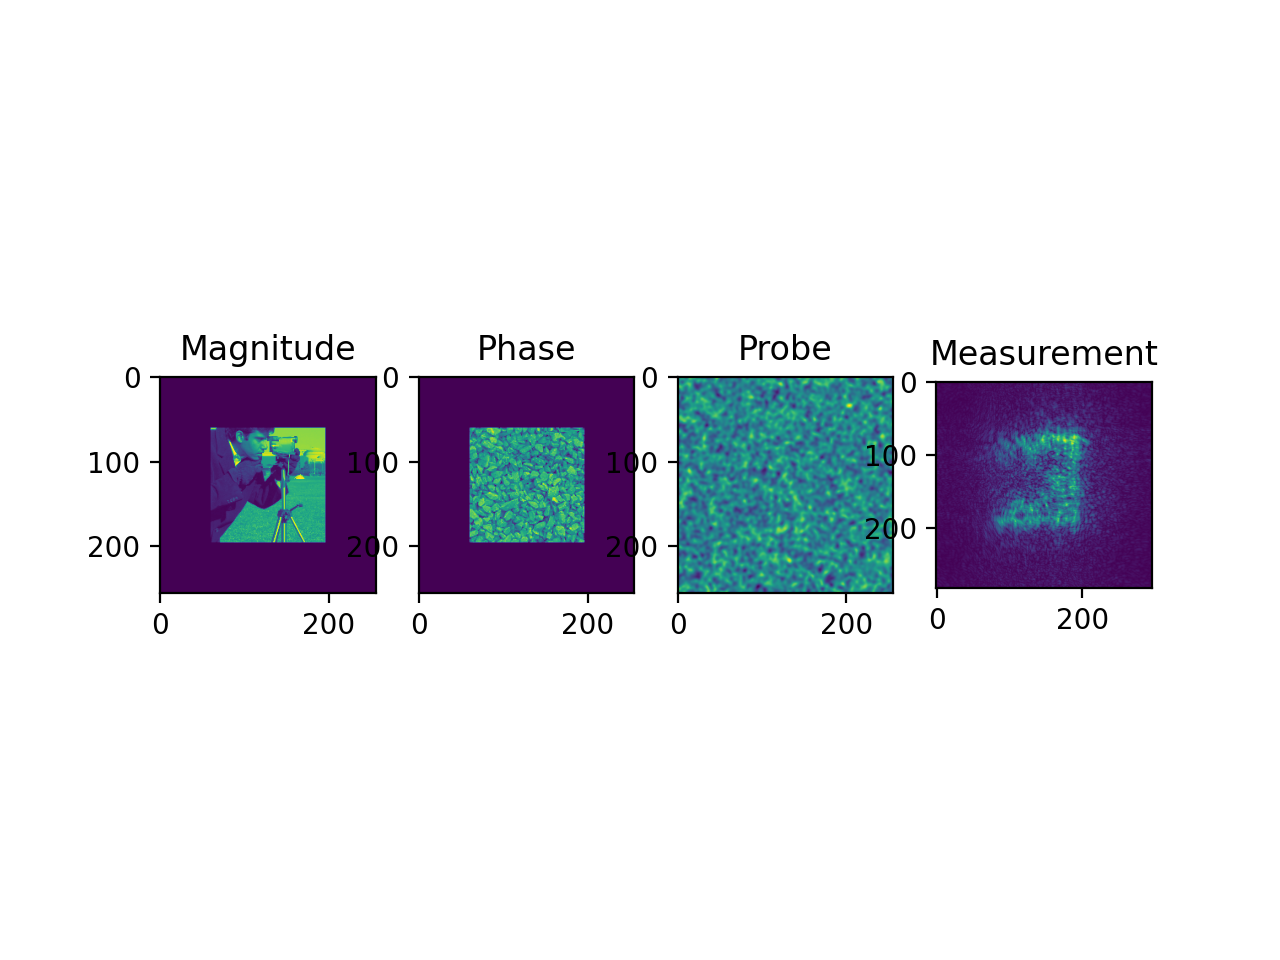

In [8]:
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]

inputs = {
"path" : "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 20, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 30, #keV
"detector_distance": 1, # meter
"distance": 1, # meter
"detector_pixel_size": 600e-9,
"probe_steps_xy": [5,5], # pixels
"n_of_angles": 0,
"source_distance": 1,
}


inputs['iterations'] = 10    
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

n_pixels = 1536
wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength
dx = wavelength*inputs["detector_distance"]/(n_pixels*inputs["detector_pixel_size"])
inputs['object_pixel'] = dx

def get_positions_array(probe_steps_xy,frame_shape,random_positions=True):

    dx, dy = probe_steps_xy # probe step size in each direction
    y_pxls = np.array([5,10,15,20,25])
    x_pxls = y_pxls

    if random_positions == True:
        x_pxls,y_pxls = apply_random_shifts_to_positions(x_pxls,y_pxls,sigma = 10)

    positionsY,positionsX = np.meshgrid(y_pxls,x_pxls)
    
    if 0: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positionsX,positionsY,'x',label='Original')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    
    return positionsX.flatten(),positionsY.flatten()

def set_object_frame(y_pxls, x_pxls,frame,probe,object_offset,path,save=True):
    obj = np.zeros(set_object_size_pxls(x_pxls,y_pxls,probe.shape,object_offset),dtype=complex)
    obj[object_offset:object_offset+frame.shape[0],object_offset:object_offset+frame.shape[1]] = frame
    return obj

def get_simulated_data(inputs, probe_steps_xy,random_positions=True,use_bad_points=False, add_position_errors=False,object_offset = 5):

    """ Create object """
    phase = np.array( np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel256.npy')) # Load Imagem
    magnitude = np.array( np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera256.npy')) # Load Imagem

    A = 60
    magnitude[0:A,:] = magnitude[-A::,:] = 0
    magnitude[:,0:A] = magnitude[:,-A::] = 0
    phase[0:A,:] = phase[-A::,:] = 0
    phase[:,0:A] = phase[:,-A::] = 0    
    
    """ Create Probe """
    probe = np.random.rand(*magnitude.shape)
    probe = scipy.ndimage.gaussian_filter(probe,2)
    probe = probe/np.max(probe)
    probe = probe * np.exp(1j*np.pi*probe)
    
    positionsX,positionsY = get_positions_array(probe_steps_xy,probe.shape,random_positions)
    model_object = np.abs(magnitude/np.max(magnitude))*np.exp(1j*np.pi*phase/np.max(phase))
    
    fig, ax = plt.subplots(1,4,dpi=200)
    ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
    ax[1].imshow(phase), ax[1].set_title('Phase')
    ax[2].imshow(np.abs(probe)), ax[2].set_title('Probe')

    model_object = set_object_frame(positionsY, positionsX,model_object,probe,object_offset,'',save=False)

    difpad = sscCdi.propagation.fresnel_propagator_cone_beam(model_object,inputs["wavelength"],inputs["detector_pixel_size"],inputs["distance"],inputs["source_distance"])
    ax[3].imshow(np.abs(difpad)), ax[3].set_title('Measurement')

    
    print('Model object:',model_object.shape)
    print('Probe: ',probe.shape)
    
    difpads = []
    for px,py in zip(positionsX,positionsY):
    
        """ Exit wave-field """
        W = model_object[py:py+probe.shape[0],px:px+probe.shape[1]]*probe
    
        """ Propagation """
        difpad = sscCdi.propagation.fresnel_propagator_cone_beam(W,inputs["wavelength"],inputs["detector_pixel_size"],inputs["distance"],inputs["source_distance"])
        # difpad = np.fft.fft2(W)
        # difpad = np.fft.fftshift(difpad)
        
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
        
        difpads.append(difpad)

    positions = np.hstack((np.array([positionsX]).T ,np.array([positionsY]).T)) # adjust positions format for proper input
    difpads = np.asarray(difpads)
    
    if add_position_errors:
        max_error = 0.1*np.mean(positions)
        positions_errors = max_error*np.random.rand(*positions.shape)
        positions += positions_errors
        return difpads, positions, model_object, probe, positions_errors
    else:
        positions_errors = []
        return difpads, positions, model_object, probe, positions_errors

difpads, positions, model_object, probe, positions_errors = get_simulated_data(inputs, inputs["probe_steps_xy"])




# probe_guess = model_probe 
# probe_guess = get_circular_mask(probe.shape[0],0.3)
probe_guess = np.ones_like(probe) + 1j
# probe_guess = probe

obj_guess = np.ones_like(model_object) # constant object

iterations = 50
n_of_modes = 1

inputs['iterations'] = iterations    
inputs["n_of_modes"] = n_of_modes

inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.01 # RAAR; small value to add to probe/object update denominator

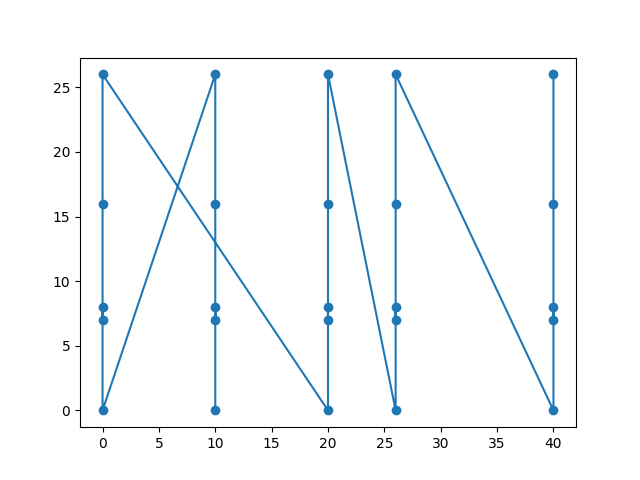

In [16]:
plt.figure()
plt.plot(positions[:,0],positions[:,1],'o-')

In [9]:
# sscCdi.deploy_visualizer(difpads)

	Iteration 0/50 	Error: 2.10e+05
	Iteration 1/50 	Error: 2.61e+04
	Iteration 2/50 	Error: 1.91e+04
	Iteration 3/50 	Error: 1.77e+04
	Iteration 4/50 	Error: 1.73e+04
	Iteration 5/50 	Error: 1.72e+04
	Iteration 6/50 	Error: 1.72e+04
	Iteration 7/50 	Error: 1.71e+04
	Iteration 8/50 	Error: 1.71e+04
	Iteration 9/50 	Error: 1.70e+04
	Iteration 10/50 	Error: 1.69e+04
	Iteration 11/50 	Error: 1.69e+04
	Iteration 12/50 	Error: 1.68e+04
	Iteration 13/50 	Error: 1.67e+04
	Iteration 14/50 	Error: 1.67e+04
	Iteration 15/50 	Error: 1.66e+04
	Iteration 16/50 	Error: 1.66e+04
	Iteration 17/50 	Error: 1.65e+04
	Iteration 18/50 	Error: 1.64e+04
	Iteration 19/50 	Error: 1.64e+04
	Iteration 20/50 	Error: 1.64e+04
	Iteration 21/50 	Error: 1.63e+04
	Iteration 22/50 	Error: 1.63e+04
	Iteration 23/50 	Error: 1.62e+04
	Iteration 24/50 	Error: 1.62e+04
	Iteration 25/50 	Error: 1.62e+04
	Iteration 26/50 	Error: 1.62e+04
	Iteration 27/50 	Error: 1.61e+04
	Iteration 28/50 	Error: 1.61e+04
	Iteration 29/50 	Error:

(<matplotlib.image.AxesImage at 0x7f6aba6d7190>, Text(0.5, 1.0, 'Probe'))

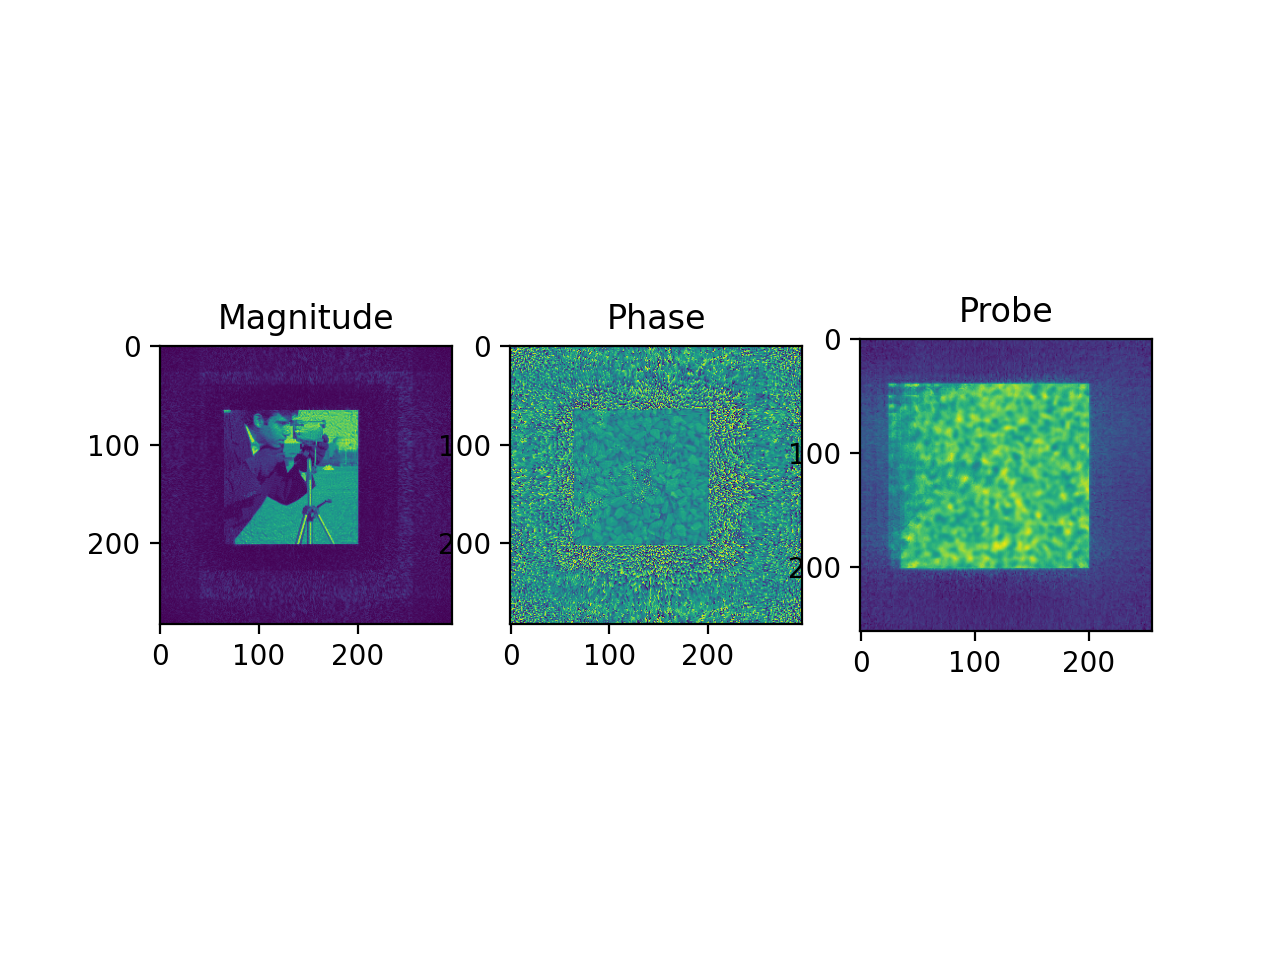

In [11]:
RAAR_obj, RAAR_probes, RAAR_error = sscCdi.ptychography.RAAR_multiprobe_cupy(difpads,positions,obj_guess,probe_guess,inputs)
RAAR_obj.shape, RAAR_probes.shape

fig, ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(np.abs(RAAR_obj)), ax[0].set_title('Magnitude')
ax[1].imshow(np.angle(RAAR_obj)), ax[1].set_title('Phase')
ax[2].imshow(np.abs(RAAR_probes[0])), ax[2].set_title('Probe')